# NIKE vs ADDIDAS SHOE CLASSIFIER

This is rework of an interesting github project I have come accross, This dataset is form the following [github project](https://github.com/CShorten/NIKE_vs_ADIDAS/blob/master/NIKE_ADIDAS_Classifier.ipynb) thought I should try out CNN myself. Lets go and explore the dataset and model


In [1]:
import numpy as np
import tensorflow as tf
import os
from random import shuffle
from tqdm import tqdm
import matplotlib.pyplot as plt
from PIL import Image
%matplotlib inline

In [2]:
IMG_SIZE = 120
TRAIN_DIR = './TRAIN'
TEST_DIR = './TEST'

In [3]:
def label_img(img):
    # Images are formatted as: ADIDAS_1, NIKE_3 ...
    word_label = img.split('_')[0]
    if word_label == 'NIKE': return [1,0] #one hot encoding
    elif word_label == 'ADIDAS': return [0,1] #one hot encoding

In [4]:
def create_train_data():
    train_data = []
    for img in tqdm(os.listdir(TRAIN_DIR)):
        label = label_img(img)
        path = os.path.join(TRAIN_DIR, img)
        ############################################################
        #    This part is different from sentdex's tutorial
        # Chose to use PIL instead of cv2 for image pre-processing
        ############################################################
        
        img = Image.open(path) #Read image syntax with PIL Library
        img = img.convert('L') #Grayscale conversion with PIL library
        img = img.resize((IMG_SIZE, IMG_SIZE), Image.ANTIALIAS) #Resizing image syntax with PIL Library
        
        ############################################################
        
        train_data.append([np.array(img), np.array(label)])
    shuffle(train_data)
    np.save('train_data.npy', train_data) #.npy extension = numpy file
    return train_data


In [5]:
def process_test_data():
    test_data = []
    for img in tqdm(os.listdir(TEST_DIR)):
        path = os.path.join(TEST_DIR, img)
        if "DS_Store" not in path:
            #img_num = img.split('_')[1] #images are formatted 'NIKE_2', 'ADIDAS_56'..
            label = label_img(img)
            #PIL LIBRARY instead of cv2
            img = Image.open(path)
            img = img.convert('L')
            img = img.resize((IMG_SIZE, IMG_SIZE), Image.ANTIALIAS)
        
            test_data.append([np.array(img),  np.array(label)])
    shuffle(test_data)
    np.save('test_data.npy', test_data)
    return test_data
        

In [9]:
train_data = create_train_data()
test_data = process_test_data()

100%|██████████| 40/40 [00:00<00:00, 290.86it/s]


In [10]:

X_train = np.array([i[0] for i in train_data]).reshape(-1, IMG_SIZE, IMG_SIZE, 1)
y_train = np.array([i[1] for i in train_data])

X_test = np.array([i[0] for i in test_data]).reshape(-1, IMG_SIZE, IMG_SIZE, 1)
y_test = np.array([i[1] for i in test_data])
print(X_train.shape,y_train.shape)

(100, 120, 120, 1) (100, 2)


In [11]:
def image_preprocess(X):
    X = X / 255
    return X

In [12]:
X_train = image_preprocess(X_train)
X_test = image_preprocess(X_test)

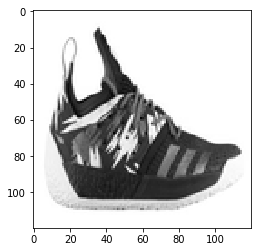

In [15]:

plt.imshow(X_train[43].reshape(120,120), cmap = 'gist_gray')



## Neural Network Architecture

Lets model a CNN network and whether it can predict Nike or Addidas 
0 - Nike
1 - Addidas

Also define our hyper parameters

First lets overfit the model 

In [83]:
learning_rate = 0.001
epochs = 10 
batch_size = 10
keep_prob = 0.8
num_classes = 2
img_size = 120 #120 X 120
iterations = 100

In [17]:
def batches_generator(batch_size, X, y,
                      shuffle=True, allow_smaller_last_batch=True):
    """Generates padded batches of tokens and tags."""
    
    n_samples = X.shape[0]
    if shuffle:
        order = np.random.permutation(n_samples)
    else:
        order = np.arange(n_samples)

    n_batches = n_samples // batch_size
    if allow_smaller_last_batch and n_samples % batch_size:
        n_batches += 1
        
    X_shuffle = X[order,:,:,:]
    y_shuffle = y[order,]
    for k in range(n_batches):
        batch_start = k * batch_size
        batch_end = min((k + 1) * batch_size, n_samples)
        current_batch_size = batch_end - batch_start
        batch_x = X_shuffle[batch_start:batch_end]
        batch_y = y_shuffle[batch_start:batch_end]
        
        yield batch_x, batch_y

In [84]:
class CNNModelSimple():
    
    def __init__(self):
        self.build_model()
        self.loss_prediction()
        self.optimizer()
        
        
        
    
    def build_model(self):
        
        self.input_x = tf.placeholder(dtype=tf.float32,shape=[None,img_size,img_size,1], name='input_x')
        self.labels = tf.placeholder(dtype=tf.float32,shape=[None,num_classes], name="label")
        self.keep_prob =  tf.placeholder_with_default(tf.cast(1.0, tf.float32), shape=[])
        
        conv1 = tf.layers.conv2d(self.input_x,filters=8,kernel_size=[3,3], padding='same',
                                activation=tf.nn.relu, kernel_initializer=tf.contrib.layers.xavier_initializer())
        
        conv2 = tf.layers.conv2d(conv1,filters=16,kernel_size=[3,3], padding='same',
                                activation=tf.nn.relu, kernel_initializer=tf.contrib.layers.xavier_initializer())
        
        pool1 = tf.layers.max_pooling2d(inputs=conv2,pool_size=[2,2], strides=2)
        
        conv3 = tf.layers.conv2d(pool1,filters=32,kernel_size=[5,5], padding='same',
                                activation=tf.nn.relu, kernel_initializer=tf.contrib.layers.xavier_initializer())
        conv4 = tf.layers.conv2d(conv3,filters=120,kernel_size=[5,5], padding='same',
                                activation=tf.nn.relu, kernel_initializer=tf.contrib.layers.xavier_initializer())
        
        pool2 = tf.layers.max_pooling2d(inputs=conv4,pool_size=[2,2], strides=2)
        
        
        dropout_1 = tf.nn.dropout(pool2,self.keep_prob)
        
       
        flattened =  tf.layers.flatten(dropout_1)
        
        dense1 =  tf.layers.dense(inputs=flattened, units=50, activation=tf.nn.relu, kernel_initializer=tf.initializers.random_normal(seed=10),
                                  kernel_regularizer= tf.contrib.layers.l2_regularizer(scale=0.1))
        
        dense2 =  tf.layers.dense(inputs=dense1, units=25, activation=tf.nn.relu, kernel_initializer=tf.initializers.random_normal(seed=10),
                                  kernel_regularizer= tf.contrib.layers.l2_regularizer(scale=0.1))
        
        self.logits =  tf.layers.dense(inputs=dense2, units=num_classes)
        
    def loss_prediction(self):
        self.y_hat  = tf.nn.softmax(self.logits)
        self.prediction = tf.argmax(self.y_hat,1)
        correct_prediction = tf.equal(self.prediction, tf.argmax(self.labels,1))
        self.accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
        self.loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=self.logits, labels=self.labels))
        
    def optimizer(self):
        self.train_op = tf.train.AdamOptimizer(learning_rate).minimize(self.loss)
        
    def train_batch(self, sess, batch_x, batch_y, dropout_keep_prob):
        _, loss_val =  sess.run([self.train_op,self.loss], feed_dict= {
           self.input_x:batch_x,
           self.labels:batch_y,
           self.keep_prob:dropout_keep_prob
       })
        return _,loss_val
    def get_accuracy(self, sess, batch_x, batch_y):
        acc_val = sess.run(self.accuracy, feed_dict= { self.input_x:batch_x, self.labels:batch_y, 
                                                      self.keep_prob: 1.0})
        return acc_val
    def predict(self,sess,batch_x):
        prediction = sess.run(self.prediction, feed_dict={
            self.input_x:batch_x,
            self.keep_prob: 1.0
        })
        return prediction
        
    def save(self,sess):
        self.saver = tf.train.Saver()
        self.model_dir = 'tfmodel/my-model'
        self.saver.save(sess,self.model_dir)
    
    def load2(self, sess):
        latest_checkpoint = tf.train.latest_checkpoint(self.model_dir)
        if latest_checkpoint:
            print("Loading model checkpoint {} ...\n".format(latest_checkpoint))
            self.saver.restore(sess, latest_checkpoint)
            print("Model loaded")
    def load(self,sess):
        new_saver = tf.train.import_meta_graph(self.model_dir+'.meta')
        new_saver.restore(sess, self.model_dir)

In [85]:
model = CNNModelSimple()

In [88]:
sess = tf.Session()

In [89]:
# WITHOUT BATCH
sess.run(tf.global_variables_initializer())
for i in range(iterations+1):
    _, loss_val  = model.train_batch(sess,batch_x=X_train, batch_y=y_train, dropout_keep_prob=0.7)
    
    #print("Batch Cost",loss_val)
    if(i % 10 == 0 and i !=0):   
        acc_val = model.get_accuracy(sess,X_test,y_test)
        print('Test set Accuaracy Epoch %d, loss %f accuracy %f' % (i+1, loss_val, acc_val))
test_acc = model.get_accuracy(sess,X_test,y_test)
print('Model Accuracy on Test Set',test_acc)


Test set Accuaracy Epoch 11, loss 1.231810 accuracy 0.600000
Test set Accuaracy Epoch 21, loss 0.660424 accuracy 0.725000
Test set Accuaracy Epoch 31, loss 0.445924 accuracy 0.800000
Test set Accuaracy Epoch 41, loss 0.328875 accuracy 0.825000
Test set Accuaracy Epoch 51, loss 0.175928 accuracy 0.875000
Test set Accuaracy Epoch 61, loss 0.052077 accuracy 0.900000
Test set Accuaracy Epoch 71, loss 0.052329 accuracy 0.875000
Test set Accuaracy Epoch 81, loss 0.016836 accuracy 0.925000
Test set Accuaracy Epoch 91, loss 0.006846 accuracy 0.925000
Test set Accuaracy Epoch 101, loss 0.010489 accuracy 0.925000
Model Accuracy on Test Set 0.925


## Hurray our model got 92 % on Test data

Lets verify some the images ourself

In [91]:
prediction = model.predict(sess,X_test)
print(prediction)

[0 1 1 0 0 0 0 0 1 0 1 0 1 1 0 1 0 1 0 1 0 0 1 0 0 0 1 0 0 1 1 0 0 1 1 1 0
 1 0 0]


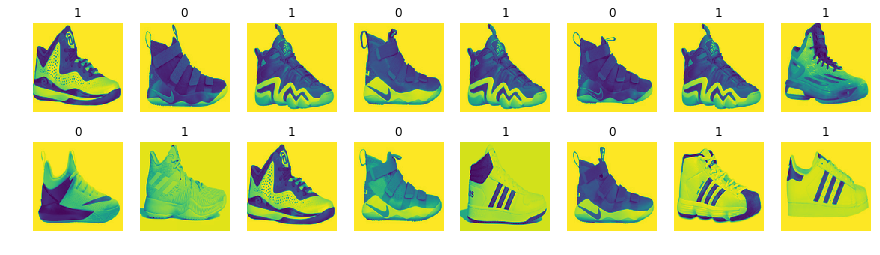

In [95]:
cols = 8
rows = 2
fig = plt.figure(figsize=(2 * cols - 1, 2.5 * rows - 1))
for i in range(cols):
    for j in range(rows):
        random_index = np.random.randint(0, len(y_test))
        ax = fig.add_subplot(rows, cols, i * rows + j + 1)
        ax.grid('off')
        ax.axis('off')
        ax.imshow(X_test[random_index, :].reshape(img_size,img_size))
        ax.set_title(np.argmax(y_test[random_index]))
plt.show()

In [ ]:
sess.close()

In [93]:
from sklearn.metrics import confusion_matrix
confusion_matrix(np.argmax(y_test,1),prediction)

array([[20,  0],
       [ 3, 17]])

## Conclusion

We had a small dataset arround 140 samples. Our model predicted some of the addidas shoes as nike shoes, but thats ok for some shoes even I could find the identify the brands.

## Points to consider

* I have adjusted learning rate  many times
* Iterations
* Modfied CNN network architecture
* Obiviously filter sizes and hidden units in dense layer.
* Played around with intializer and regularizer

I m really happy that I could evaluate a new dataset and my CNN architecure. And watch it improve over tries.

## Todo

* Next up I should learn to visualize filters and see how our model understood the various features from the shoes.

### Thanks for read
follow me on twitter @billa2ram
